<a href="https://colab.research.google.com/github/ashiq24/All-for-java/blob/master/NonLinear_Batch_Effect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title All Includes
import tensorflow as tf
import csv
from sklearn import datasets
import numpy as np
from sklearn import preprocessing
from tensorflow.keras import layers, losses
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from numpy import random
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.patches as mpatches
import matplotlib
import matplotlib.lines as mlines

In [3]:
np.random.seed(10110)

# ML MODEL 
## check model for hig dimensional input


In [4]:

def get_hybrid_model_2(feature_dimension, embedding_dim, platform_number, biological_label):

    inputs=tf.keras.Input(shape=(feature_dimension,))
    en_h1=tf.keras.layers.Dense(embedding_dim[0],activation='selu',name='en_h1', kernel_regularizer='l2')(inputs)
    en_h2=tf.keras.layers.Dense(embedding_dim[1],activation='selu',name='en_h2' , kernel_regularizer='l2')(en_h1)
    en_h3=tf.keras.layers.Dense(embedding_dim[2],activation='selu',name='en_h3' , kernel_regularizer='l2')(en_h2)
    embedding=tf.keras.layers.Dense(embedding_dim[3],activation='selu',name='embedding')(en_h3)

    encoder_model=tf.keras.Model(inputs=inputs,outputs=[embedding],name='encoder_model')

    #start of decoder
    de_h1=tf.keras.layers.Dense(embedding_dim[2],activation='selu',name='de_h1', kernel_regularizer='l2')(embedding)
    de_h2=tf.keras.layers.Dense(embedding_dim[1],activation='selu',name='de_h2', kernel_regularizer='l2')(de_h1)
    de_h3=tf.keras.layers.Dense(embedding_dim[0],activation='selu',name='de_h3', kernel_regularizer='l2')(de_h2)
    de_output=tf.keras.layers.Dense(feature_dimension,activation='selu',name='de_output', kernel_regularizer='l2')(de_h3)

    #start of platform detection layer
    #p_h1=tf.keras.layers.Dense(20,activation='selu',name='p_h1')(embedding)
    #p_h2=tf.keras.layers.Dense(30,activation='selu',name='p_h2')(p_h1)
    #p_h3=tf.keras.layers.Dense(10,activation='selu',name='p_h3')(p_h2)
    p_output=tf.keras.layers.Dense(platform_number,activation='sigmoid',name='p_output',  kernel_regularizer='l2')(embedding)
    
    #biological label detection
    #er_h1=tf.keras.layers.Dense(20,activation='selu',name='er_h1')(embedding)
    #er_h2=tf.keras.layers.Dense(30,activation='selu',name='er_h2')(er_h1)
    #=tf.keras.layers.Dense(10,activation='selu',name='er_h3')(er_h2)
    er_output=tf.keras.layers.Dense(biological_label,activation='sigmoid',name='er_output',  kernel_regularizer='l2')(embedding)
    
    hybrid_model=tf.keras.Model(inputs=inputs,outputs=[p_output,de_output,er_output],name="hybridmodel")
    tf.keras.utils.plot_model(hybrid_model, "myfirstmodel.png",show_shapes=True)
    
    
    return hybrid_model,encoder_model
    
def get_hybrid_model_1(feature_dimension, embedding_dim, platform_number, biological_label, islarge = -1):

    inputs=tf.keras.Input(shape=(feature_dimension,))

    #for high dimentional input
    inputs_1 = tf.keras.layers.Lambda(lambda x: 1*x )(inputs)
    if islarge!= -1:
      inputs_1 = tf.keras.layers.Dropout(islarge)(inputs_1)

    en_h1=tf.keras.layers.Dense(embedding_dim[0],activation='selu',name='en_h1', kernel_regularizer='l2')(inputs_1)
    en_h1 = tf.keras.layers.Dropout(0.25)(en_h1)
    en_h2=tf.keras.layers.Dense(embedding_dim[1],activation='selu',name='en_h2' , kernel_regularizer='l2')(en_h1)
    en_h2 = tf.keras.layers.Dropout(0.15)(en_h2)
    embedding=tf.keras.layers.Dense(embedding_dim[2],activation='selu',name='embedding')(en_h2)

    encoder_model=tf.keras.Model(inputs=inputs,outputs=[embedding],name='encoder_model')

    #start of decoder
    de_h1=tf.keras.layers.Dense(embedding_dim[1],activation='selu',name='de_h1', kernel_regularizer='l2')(embedding)
    de_h1 = tf.keras.layers.Dropout(0.15)(de_h1)
    de_h2=tf.keras.layers.Dense(embedding_dim[0],activation='selu',name='de_h2', kernel_regularizer='l2')(de_h1)
    de_h2 = tf.keras.layers.Dropout(0.25)(de_h2)
    de_output=tf.keras.layers.Dense(feature_dimension,activation='selu',name='de_output', kernel_regularizer='l2')(de_h2)

    #start of platform detection layer
    if platform_number ==1:
      p_output=tf.keras.layers.Dense(platform_number,activation='sigmoid',name='p_output',  kernel_regularizer='l2')(embedding)
    else:
      p_output=tf.keras.layers.Dense(platform_number,activation='softmax',name='p_output',  kernel_regularizer='l2')(embedding)

    
    #biological label detection
    if biological_label ==1:
      er_output=tf.keras.layers.Dense(biological_label,activation='sigmoid',name='er_output',  kernel_regularizer='l2')(embedding)
    else:
      er_output=tf.keras.layers.Dense(biological_label,activation='softmax',name='er_output',  kernel_regularizer='l2')(embedding)

    
    hybrid_model=tf.keras.Model(inputs=inputs,outputs=[p_output,de_output,er_output],name="hybridmodel")
    tf.keras.utils.plot_model(hybrid_model, "myfirstmodel.png",show_shapes=True)
    
    
    return hybrid_model,encoder_model


#  Python Code of KBET

In [5]:

from sklearn.neighbors import KDTree
from scipy.stats import chisquare

def Kbet(x, batch_info, K):
  F_o = []
  for i in sorted(list(set(batch_info))):
    F_o.append(np.count_nonzero(batch_info ==i))
  s = sum(F_o)
  F_o = [int(i*K/s) for i in F_o]
  print(F_o)

  tree = KDTree(x)
  kx = tree.query(x, k=K, return_distance=False, dualtree=True)
  avg_rejection = 0
  for i in kx:
    #print(i)
    i = batch_info[i]
    F_k = []
    for j in sorted(list(set(i))):
      F_k.append(np.count_nonzero(i == j))

    c,p = chisquare(F_k,F_o)
    if p<0.05:
      avg_rejection+=1
  avg_rejection=avg_rejection/(len(x))

  return avg_rejection

def Run_Kbet(x, batch_info, K, sub_sample= None):

  if sub_sample == None:
    k_r = Kbet(x, batch_info, K)
  
  return k_r




# Lisi Code


In [6]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from typing import Iterable


def compute_lisi(
    X: np.array,
    metadata: pd.DataFrame,
    label_colnames: Iterable[str],
    perplexity: float=30
):
    """Compute the Local Inverse Simpson Index (LISI) for each column in metadata.
    LISI is a statistic computed for each item (row) in the data matrix X.
    The following example may help to interpret the LISI values.
    Suppose one of the columns in metadata is a categorical variable with 3 categories.
        - If LISI is approximately equal to 3 for an item in the data matrix,
          that means that the item is surrounded by neighbors from all 3
          categories.
        - If LISI is approximately equal to 1, then the item is surrounded by
          neighbors from 1 category.
    
    The LISI statistic is useful to evaluate whether multiple datasets are
    well-integrated by algorithms such as Harmony [1].
    [1]: Korsunsky et al. 2019 doi: 10.1038/s41592-019-0619-0
    """
    n_cells = metadata.shape[0]
    n_labels = len(label_colnames)
    # We need at least 3 * n_neigbhors to compute the perplexity
    knn = NearestNeighbors(n_neighbors = perplexity * 3, algorithm = 'kd_tree').fit(X)
    distances, indices = knn.kneighbors(X)
    # Don't count yourself
    indices = indices[:,1:]
    distances = distances[:,1:]
    # Save the result
    lisi_df = np.zeros((n_cells, n_labels))
    for i, label in enumerate(label_colnames):
        labels = pd.Categorical(metadata[label])
        n_categories = len(labels.categories)
        simpson = compute_simpson(distances.T, indices.T, labels, n_categories, perplexity)
        lisi_df[:,i] = 1 / simpson
    return lisi_df


def compute_simpson(
    distances: np.ndarray,
    indices: np.ndarray,
    labels: pd.Categorical,
    n_categories: int,
    perplexity: float,
    tol: float=1e-5
):
    n = distances.shape[1]
    P = np.zeros(distances.shape[0])
    simpson = np.zeros(n)
    logU = np.log(perplexity)
    # Loop through each cell.
    for i in range(n):
        beta = 1
        betamin = -np.inf
        betamax = np.inf
        # Compute Hdiff
        P = np.exp(-distances[:,i] * beta)
        P_sum = np.sum(P)
        if P_sum == 0:
            H = 0
            P = np.zeros(distances.shape[0])
        else:
            H = np.log(P_sum) + beta * np.sum(distances[:,i] * P) / P_sum
            P = P / P_sum
        Hdiff = H - logU
        n_tries = 50
        for t in range(n_tries):
            # Stop when we reach the tolerance
            if abs(Hdiff) < tol:
                break
            # Update beta
            if Hdiff > 0:
                betamin = beta
                if not np.isfinite(betamax):
                    beta *= 2
                else:
                    beta = (beta + betamax) / 2
            else:
                betamax = beta
                if not np.isfinite(betamin):
                    beta /= 2
                else:
                    beta = (beta + betamin) / 2
            # Compute Hdiff
            P = np.exp(-distances[:,i] * beta)
            P_sum = np.sum(P)
            if P_sum == 0:
                H = 0
                P = np.zeros(distances.shape[0])
            else:
                H = np.log(P_sum) + beta * np.sum(distances[:,i] * P) / P_sum
                P = P / P_sum
            Hdiff = H - logU
        # distancesefault value
        if H == 0:
            simpson[i] = -1
        # Simpson's index
        for label_category in labels.categories:
            ix = indices[:,i]
            q = labels[ix] == label_category
            if np.any(q):
                P_sum = np.sum(P[q])
                simpson[i] += P_sum * P_sum
    return simpson

#Simulaion Bimodal data generation 

In [297]:
 
def Linear_noise(mu,sig,dimen,num):
  return random.multivariate_normal(mu, sig, num)

def sigmoid(x):
  return (1 / (1 + np.exp(-x)))

def Non_linear_noise_1(mu,sig,dimen,num, W1, W2, W3):
  ln = Linear_noise(mu,sig,dimen,num)

  ln = np.matmul(ln ,W1)

  #ln = np.concatenate( [np.power(ln[:,:ln.shape[1]//2],4), np.power( ln[:,ln.shape[1]//2:], 2) ], axis =1 )
  ln = ln*np.tanh(ln)

  #ln = np.matmul(ln ,W2)

  #ln =  np.concatenate( [np.tanh(ln[:,:ln.shape[1]//2]), sigmoid( ln[:,ln.shape[1]//2:]) ], axis =1 )

  #ln = ln / np.max(ln)

  
  return ln

def Non_linear_noise_2(mu,sig,dimen,num, W1, W2, W3):
  ln = Linear_noise(mu,sig,dimen,num)
  t = np.array([ [i[j]**W3[0][j] for j in range(i.shape[0]) ] for i in ln ])
  #t = np.concatenate( [np.power(ln[:,:ln.shape[1]//2],7), np.power( ln[:,ln.shape[1]//2:], 9) ], axis =1 )
  ln = np.matmul(t ,W1) #- ln - np.power(ln,2)

  #ln = np.concatenate( [np.power(ln[:,:ln.shape[1]//2],3), np.power( ln[:,ln.shape[1]//2:], 3) ], axis =1 )
  #ln = np.matmul(ln,W2)

  #ln = np.tanh(ln)
  #ln = ln*np.sin(ln)
  
  #ln = MinMaxScaler(feature_range=(-1,1)).fit_transform(ln)
  #ln = ln / np.max([np.abs(np.min(ln)), np.abs(np.max(ln))])
  #ln = ln*np.sin(ln)
  
  #ln = 1/(1+ln)
  ln = sigmoid(ln)
  return ln

def linear_noise_2(mu,sig,dimen,num, W1, W2, W3):
  ln = Linear_noise(mu,0.5*sig,dimen,num)

  return   ln
def normal_data(mu1,mu2,sig,num):
  data_bulk = random.multivariate_normal(mu1,sig,num//2)
  data_bulk_2 = random.multivariate_normal(mu2,sig,num-num//2)
  data_bulk = np.concatenate([data_bulk,data_bulk_2],axis=0)
  np.random.shuffle(data_bulk)
  return data_bulk

def gen_data(bio_var=2, batch_var=2, dimen=100, bio_param=None, batch_param = None, noise="lin", num = 1000):
  mu_1 = random.uniform(-3,5,(bio_var,dimen)) # model 1
  mu_2 = random.uniform(-5,3,(bio_var,dimen)) # model 2

  sig = datasets.make_spd_matrix(dimen)

  data_1 = normal_data(mu_1[0],mu_1[1],sig,num//2)
  data_2 = normal_data(mu_2[0],mu_2[1],sig,num-num//2)

  data = np.concatenate([data_1,data_2],axis=0)

  noise_mu_1 = random.uniform(-2,2,dimen)
  noise_mu_2 = random.uniform(0,1,dimen)
  noise_sig = datasets.make_spd_matrix(dimen)

  weight11 = random.uniform(-2,2,(dimen, dimen))
  weight12 = random.uniform(-2,2,(dimen, dimen))
  weight21 = random.uniform(-2,2,(dimen, dimen))
  weight22 = random.randint(1,5,(dimen, dimen))

  noise1 = Non_linear_noise_2(noise_mu_1,noise_sig,dimen, num//4, weight11, weight12, weight22)
  noise2 = Non_linear_noise_2(noise_mu_2,noise_sig,dimen, num//4,  weight11, weight12, weight22)
  noise3 = Non_linear_noise_2(noise_mu_1,noise_sig,dimen, num//4,  weight11, weight12, weight22)
  noise4 = Non_linear_noise_2(noise_mu_2,noise_sig,dimen, num - 3*(num//4), weight11, weight12, weight22)

  noise = np.concatenate([noise1,noise2,noise3,noise4],axis=0)

  #noise = np.concatenate([Linear_noise(noise_mu_1,noise_sig,dimen, num//4),Linear_noise(noise_mu_2,noise_sig,dimen, num//4)
  #,Linear_noise(noise_mu_1,noise_sig,dimen, num//4),Linear_noise(noise_mu_2,noise_sig,dimen, num - 3*(num//4))],axis=0)

  data = data #+ noise

  bio = [0 if i<num//2  else 1 for i in range(num)]
  batch = np.concatenate([np.zeros(num//4),np.ones(num//4),np.zeros(num//4),np.ones(num - 3*num//4)],axis = 0)

  

  return data, np.array(bio), np.array(batch), noise


#Experiment on Prat Data

In [ ]:
#@ title Prat Data Loading and Training

data=csv.reader(open('/content/drive/MyDrive/DATA/pratData.csv','r'))
data=list(data)
data=data[1:]

X=[]
Y_Platform=[]
Y_ER=[]
for element in data:
    temp=element[4:]
    temp=[float(t) for t in temp]
    X.append(temp)
    if element[3]=='gpl96':
        Y_Platform.append(1.0)
    else:
        Y_Platform.append(0.0)
    Y_ER.append(float(element[2]))




In [ ]:
X=np.array(X)
scaler = MinMaxScaler()
scaler.fit(X)
X=scaler.transform(X)

#loading Biological var
Y_ER=np.array(Y_ER)

#loading batch var
Y_Platform=np.array(Y_Platform)

X_train, X_test, Y_Platform_train, Y_Platform_test,Y_ER_train,Y_ER_test = train_test_split(
X, Y_Platform,Y_ER,test_size=0.20,random_state=42)

#Getting separate validation data

X_train, X_val, Y_Platform_train, Y_Platform_val,Y_ER_train,Y_ER_val = train_test_split(
X_train, Y_Platform_train, Y_ER_train ,test_size=0.25,random_state=42)


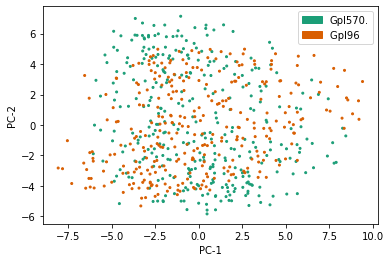

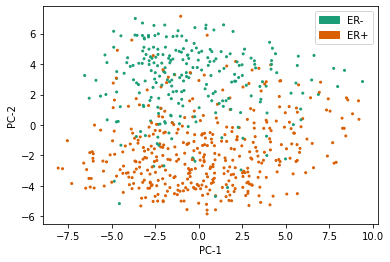

In [ ]:
X_pc = PCA(n_components = 2).fit_transform(X)

colors = ['#1b9e77','#d95f02']
plt.scatter(X_pc[:,0], X_pc[:,1], c=Y_Platform, cmap=matplotlib.colors.ListedColormap(colors),alpha=1.0, s=4.0)
plt.xlabel('PC-1', fontsize=10)
plt.ylabel('PC-2', fontsize=10)

plt.legend(handles=[mpatches.Patch(color='#1b9e77',label='Gpl570.'),
                mpatches.Patch(color='#d95f02' ,label='Gpl96 '),])
plt.savefig("prat_batch_pc.png", dpi=300)
plt.show()

plt.scatter(X_pc[:,0], X_pc[:,1], c=Y_ER,cmap=matplotlib.colors.ListedColormap(colors),alpha=1.0, s=4.0)
plt.xlabel('PC-1', fontsize=10)
plt.ylabel('PC-2', fontsize=10)
plt.legend(handles=[mpatches.Patch(color='#1b9e77',label='ER-'),
                mpatches.Patch(color='#d95f02' ,label='ER+'),])
plt.savefig("prat_er_pc.png", dpi=300)

plt.show()

In [ ]:
hybrid_model,encoder_model=get_hybrid_model_1(len(X_train[0]),[128,64,50],1,1)
losses = {
    "p_output": "binary_crossentropy",
   "de_output": "MeanSquaredError",
  "er_output": "binary_crossentropy",
}
lossWeights = {"p_output":2.0, "de_output": 1.0,"er_output":1.0}

#model check pointer 
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('model.h5', verbose=2, save_best_only=True)

hybrid_model.compile(optimizer=Adam(lr=0.0005),loss=losses,loss_weights=lossWeights,metrics={'p_output': 'accuracy', 'er_output': 'accuracy','de_output': 'mse'})
hybrid_model.fit(X_train,{"de_output": X_train, "p_output": Y_Platform_train,"er_output":Y_ER_train},steps_per_epoch = len(X_train) // 32,
                 validation_data=(X_val,
		{"de_output": X_val, "p_output": Y_Platform_val,"er_output":Y_ER_val}),
    callbacks=[model_checkpoint_callback],
    epochs=500,verbose=2)

Epoch 1/500
12/12 - 2s - loss: 10.5957 - p_output_loss: 1.0350 - de_output_loss: 0.3881 - er_output_loss: 1.4135 - p_output_accuracy: 0.5179 - de_output_mse: 0.3881 - er_output_accuracy: 0.5000 - val_loss: 9.1520 - val_p_output_loss: 1.0279 - val_de_output_loss: 0.2189 - val_er_output_loss: 0.8246 - val_p_output_accuracy: 0.4427 - val_de_output_mse: 0.2189 - val_er_output_accuracy: 0.6260

Epoch 00001: val_loss improved from inf to 9.15195, saving model to model.h5
Epoch 2/500
12/12 - 0s - loss: 8.8807 - p_output_loss: 1.0612 - de_output_loss: 0.1997 - er_output_loss: 0.9331 - p_output_accuracy: 0.5051 - de_output_mse: 0.1997 - er_output_accuracy: 0.5513 - val_loss: 7.5050 - val_p_output_loss: 0.7925 - val_de_output_loss: 0.1055 - val_er_output_loss: 0.6405 - val_p_output_accuracy: 0.4427 - val_de_output_mse: 0.1055 - val_er_output_accuracy: 0.6260

Epoch 00002: val_loss improved from 9.15195 to 7.50498, saving model to model.h5
Epoch 3/500
12/12 - 0s - loss: 7.4647 - p_output_loss: 0.

In [ ]:
hybrid_model.load_weights('model.h5')

In [ ]:
encoded_imgs = encoder_model.predict(X_test)

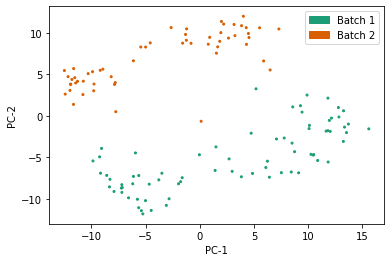

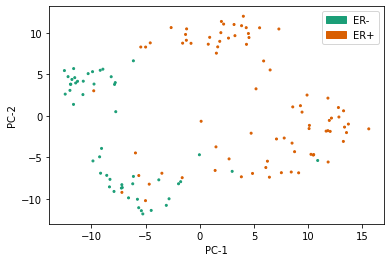

In [ ]:
encoded_imgs_pc = PCA(n_components = 2).fit_transform(encoded_imgs)
plt.scatter(encoded_imgs_pc[:,0], encoded_imgs_pc[:,1], c=Y_Platform_test, cmap=matplotlib.colors.ListedColormap(colors),alpha=1.0, s=4.0)
plt.xlabel('PC-1', fontsize=10)
plt.ylabel('PC-2', fontsize=10)
plt.savefig("prat_batch_enco.png", dpi=300)
plt.legend(handles=[mpatches.Patch(color='#1b9e77',label='Batch 1'),
                mpatches.Patch(color='#d95f02' ,label='Batch 2'),])
plt.show()
plt.scatter(encoded_imgs_pc[:,0], encoded_imgs_pc[:,1], c=Y_ER_test, cmap=matplotlib.colors.ListedColormap(colors),alpha=1.0, s=4.0)
plt.xlabel('PC-1', fontsize=10)
plt.ylabel('PC-2', fontsize=10)
plt.savefig("prat_er_enco.png", dpi=300)
plt.legend(handles=[mpatches.Patch(color='#1b9e77',label='ER-'),
                mpatches.Patch(color='#d95f02' ,label='ER+'),])
plt.show()

In [ ]:
X_encode = encoder_model.predict(X)

In [ ]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
%%R
library(devtools)
install_github('theislab/kBET')

R[write to console]: Skipping install of 'kBET' from a github remote, the SHA1 (4c9dafab) has not changed since last install.
  Use `force = TRUE` to force installation



In [ ]:
%%R -i Y_Platform_test
batch <- Y_Platform_test

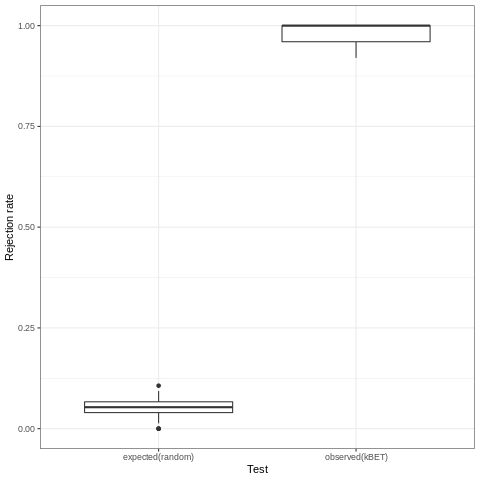

In [ ]:
%%R -i encoded_imgs
#%%R -i batch_label
library(kBET)
#batch <- rep(seq_len(10),each=20)
#data <- matrix(rpois(n = 50000, lambda = 10)*rbinom(50000,1,prob=0.5), nrow=200)
batch.estimate <- kBET(encoded_imgs ,batch, do.pca =FALSE)
test_beene = batch.estimate$stats$kBET.observed

In [ ]:
%%R
result <- batch.estimate$summary$kBET.observed

In [ ]:
x = %R result
print(x[0])

0.9812


In [ ]:
%%R -i Y_Platform
batch <- Y_Platform

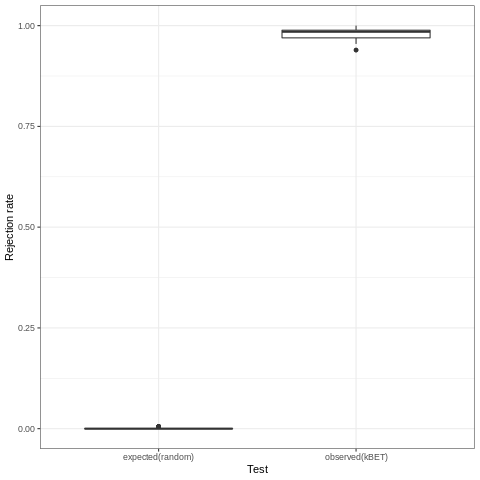

In [ ]:
%%R -i X_encode
#%%R -i batch_label
#library(kBET)
#batch <- rep(seq_len(10),each=20)
#data <- matrix(rpois(n = 50000, lambda = 10)*rbinom(50000,1,prob=0.5), nrow=200)
batch.estimate <- kBET(X_encode ,batch, do.pca =FALSE)

In [ ]:
%%R
data_beene <- batch.estimate$stats$kBET.observed
result <- batch.estimate$summary$kBET.observed

In [ ]:
x = %R result
print(x[0])

0.9828787878787879


In [ ]:
#%%R -i batch_info
#batch <- batch_info

In [ ]:
%%R -i Y_Platform_test
batch <- Y_Platform_test

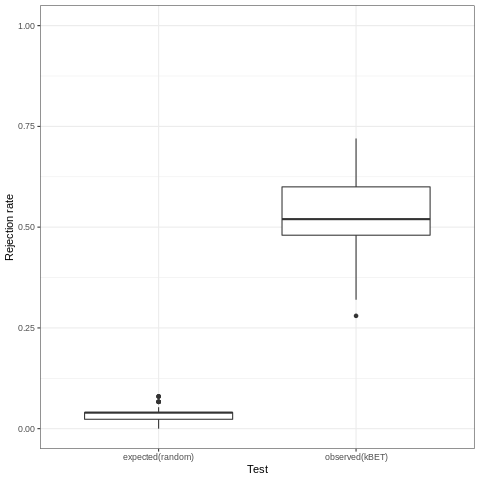

In [ ]:
%%R -i X_test
#%%R -i batch_label
library(kBET)
#batch <- rep(seq_len(10),each=20)
#data <- matrix(rpois(n = 50000, lambda = 10)*rbinom(50000,1,prob=0.5), nrow=200)
batch.estimate <- kBET(X_test ,batch)
result <- batch.estimate$summary$kBET.observed
test_kbet <- batch.estimate$stats$kBET.observed


In [ ]:
x = %R result
print(x[0])

0.5284


In [ ]:
%%R -i Y_Platform
batch <- Y_Platform

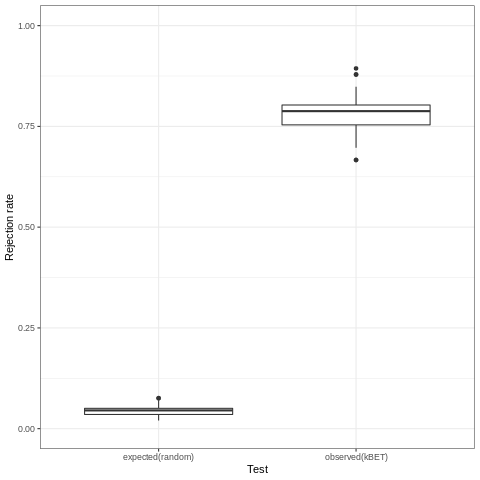

In [ ]:
%%R -i X
#%%R -i batch_label
library(kBET)
#batch <- rep(seq_len(10),each=20)
#data <- matrix(rpois(n = 50000, lambda = 10)*rbinom(50000,1,prob=0.5), nrow=200)
batch.estimate <- kBET(X ,batch)
result <- batch.estimate$summary$kBET.observed
data_kbet <- batch.estimate$stats$kBET.observed

In [ ]:
%%R
png("prat_box.png", width = 150, height = 150, units='mm', res = 300)
par(mar=c(7,5,1,1))
boxplot(test_beene, test_kbet, data_kbet,
at = c(1,2,3),
names = c("BEENE\n(Test set)", "KBET\n(Test set)", "KBET"),
las = 2,
xlab = "Rejection rate",
col = c("#1b9e77","#d95f02","#7570b3"),
border = "brown",
horizontal = TRUE,
notch = FALSE,
las=2
)
dev.off()

png 
  2 


**LISI**

In [ ]:
import pandas as pd 

In [ ]:
batch_df = pd.DataFrame(Y_Platform,columns =['batch']) 

In [ ]:
pca = PCA(n_components = 50)
#pca.fit(MinMaxScaler().fit_transform(noise))
data__pca = pca.fit_transform(MinMaxScaler().fit_transform(X))

In [ ]:

lisi_result = compute_lisi(data__pca, batch_df, ['batch'])

In [ ]:
np.median(lisi_result)

1.3741131804351574

In [ ]:
batch_df = pd.DataFrame(Y_Platform_test,columns =['batch']) 
#data__pca = pca.fit_transform(MinMaxScaler().fit_transform(data_))
lisi_result = compute_lisi(encoded_imgs, batch_df, ['batch'])
np.median(lisi_result)

1.0397366575400921

## How is the reconstruction result ?

In [ ]:
_, expressions, _ = hybrid_model.predict(X_test)

In [ ]:
x = (X_test - np.mean(X_test,axis = 0))/np.std(X_test, axis = 0)
y = (expressions - np.mean(expressions,axis = 0))/np.std(expressions, axis = 0)
col_corr = np.sum(x * y, axis = 0)/ x.shape[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [ ]:
x = X_test.T
y = expressions.T
x = (x - np.mean(x,axis = 0))/np.std(x, axis = 0)
y = (y - np.mean(y,axis = 0))/np.std(y, axis = 0)
row_corr =  np.sum(x * y, axis = 0)/ x.shape[0]

### correlation accross People

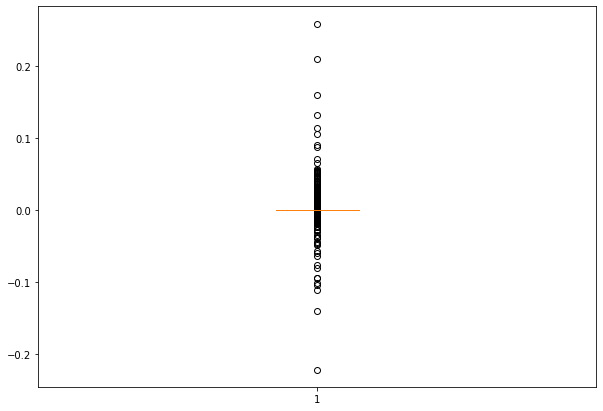

In [ ]:
#@title plot

fig = plt.figure(figsize =(10, 7)) 
  
# Creating plot 
#plt.boxplot(row_corr[~np.isnan(row_corr)]) 
plt.boxplot(col_corr[~np.isnan(col_corr)]) 
# show plot 
plt.show()

###correlation accross Gene

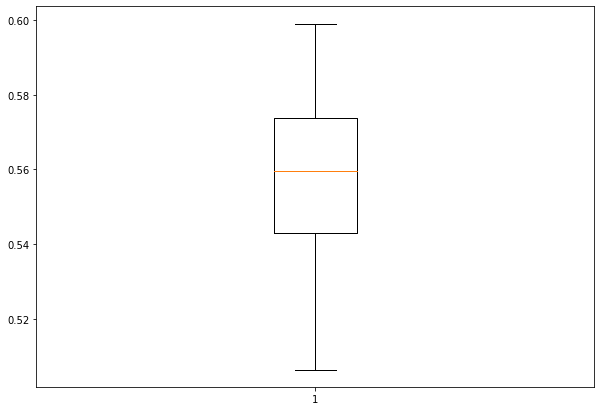

In [ ]:
#@title plot

fig = plt.figure(figsize =(10, 7)) 
  
# Creating plot 
plt.boxplot(row_corr[~np.isnan(row_corr)]) 

# show plot 
plt.show()

#Del Objects

In [ ]:
#@title delete previous objects
del hybrid_model
del encoder_model
del X_train
del X_test
del X_val
del Y_Platform_train
del Y_Platform_val
del Y_Platform_test
del Y_ER_test
del Y_ER_train
del Y_ER_val
'''def Non_linear_noise_2(mu,sig,dimen,num, W1, W2, W3):
  ln = Linear_noise(mu,sig,dimen,num)
  t = np.array([ [i[j]**W3[0][j] for j in range(i.shape[0]) ] for i in ln ])
  #t = np.concatenate( [np.power(ln[:,:ln.shape[1]//2],7), np.power( ln[:,ln.shape[1]//2:], 9) ], axis =1 )
  ln = np.matmul(t ,W1) #- ln - np.power(ln,2)

  #ln = np.concatenate( [np.power(ln[:,:ln.shape[1]//2],3), np.power( ln[:,ln.shape[1]//2:], 3) ], axis =1 )
  #ln = np.matmul(ln,W2)

  #ln = np.tanh(ln)
  #ln = MinMaxScaler(feature_range=(0,1)).fit_transform(ln)
  ln = sigmoid(ln)
  return ln'''

'def Non_linear_noise_2(mu,sig,dimen,num, W1, W2, W3):\n  ln = Linear_noise(mu,sig,dimen,num)\n  t = np.array([ [i[j]**W3[0][j] for j in range(i.shape[0]) ] for i in ln ])\n  #t = np.concatenate( [np.power(ln[:,:ln.shape[1]//2],7), np.power( ln[:,ln.shape[1]//2:], 9) ], axis =1 )\n  ln = np.matmul(t ,W1) #- ln - np.power(ln,2)\n\n  #ln = np.concatenate( [np.power(ln[:,:ln.shape[1]//2],3), np.power( ln[:,ln.shape[1]//2:], 3) ], axis =1 )\n  #ln = np.matmul(ln,W2)\n\n  #ln = np.tanh(ln)\n  #ln = MinMaxScaler(feature_range=(0,1)).fit_transform(ln)\n  ln = sigmoid(ln)\n  return ln'

## Performing K BET on Non-linear coding and Linear Encoding (PCA)

The embedding demsion is no longer 2 for visualization. The gene expression is projected to 20 dimentional space.




#Simulated Data
A bimodal multivariate gaussian distribution is used to generate simulated gene expressions. Gene expressions are sampled from two different pair of mean to simulate the effect two different biological variables (e.g. cancer or not-cancer).



In [ ]:
yo, bio_label, batch_label, noise = gen_data(2,2,1000,'',num = 1500)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


In [ ]:
print(np.max(noise), np.median(noise), np.min(noise), np.max(yo), np.min(yo), np.median(yo))

1.0 0.6200514184509556 0.0 14.925749938972935 -13.60535759340804 0.11140370140300437


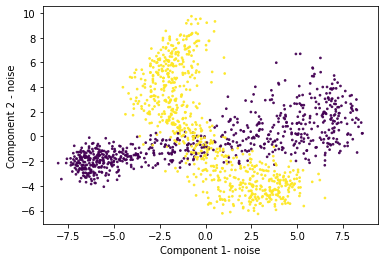

In [ ]:
pca = PCA(n_components = 2)
#pca.fit(MinMaxScaler().fit_transform(noise))
noise_pca = pca.fit_transform(MinMaxScaler().fit_transform(noise))

plt.scatter(noise_pca[:,0], noise_pca[:,1], c=batch_label[:], alpha=0.9, s=2.9)
plt.xlabel('Component 1- noise', fontsize=10)
plt.ylabel('Component 2 - noise', fontsize=10)
plt.show()

In [ ]:
pca = PCA(n_components = 2)
pca.fit(yo)
yo_pca = pca.transform(yo)

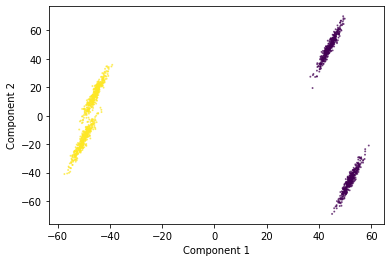

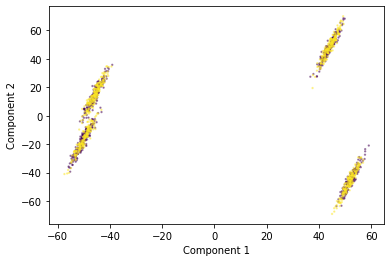

In [ ]:
plt.scatter(yo_pca[:,0], yo_pca[:,1], c=bio_label[:], alpha=0.6, s=1.0)
plt.xlabel('Component 1', fontsize=10)
plt.ylabel('Component 2', fontsize=10)
plt.show()
plt.scatter(yo_pca[:,0], yo_pca[:,1], c=batch_label[:], alpha=0.4, s=1.9)
plt.xlabel('Component 1', fontsize=10)
plt.ylabel('Component 2', fontsize=10)
plt.show()

In [ ]:
yo_ = yo +noise

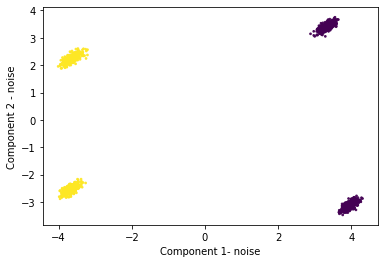

In [ ]:
pca = PCA(n_components = 2)
#pca.fit(MinMaxScaler().fit_transform(noise))
yo__pca = pca.fit_transform(MinMaxScaler().fit_transform(yo_))

plt.scatter(yo__pca[:,0], yo__pca[:,1], c=bio_label[:], alpha=0.9, s=2.9)
plt.xlabel('Component 1- noise', fontsize=10)
plt.ylabel('Component 2 - noise', fontsize=10)
plt.show()

In [ ]:
yo = yo_

In [ ]:
scaler = MinMaxScaler()
scaler.fit(yo)
yo=scaler.transform(yo)

In [ ]:
X_train, X_test, Y_Platform_train, Y_Platform_test,Y_ER_train,Y_ER_test = train_test_split(
yo, batch_label,bio_label,test_size=0.15,random_state=42)

#Getting separate validation data

X_train, X_val, Y_Platform_train, Y_Platform_val,Y_ER_train,Y_ER_val = train_test_split(
X_train, Y_Platform_train, Y_ER_train ,test_size=0.15,random_state=42)

In [ ]:
hybrid_model,encoder_model=get_hybrid_model_1(len(X_train[0]),[128,64,50],1,1)
losses = {
    "p_output": "binary_crossentropy",
   "de_output": "MeanSquaredError",
  "er_output": "binary_crossentropy",
}
lossWeights = {"p_output":2.0, "de_output": 1.0,"er_output":1.0}

#model check pointer 
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('model.h5', verbose=2, save_best_only=True)

hybrid_model.compile(optimizer=Adam(lr=0.0005),loss=losses,loss_weights=lossWeights,metrics={'p_output': 'accuracy', 'er_output': 'accuracy','de_output': 'mse'})
hybrid_model.fit(X_train,{"de_output": X_train, "p_output": Y_Platform_train,"er_output":Y_ER_train},steps_per_epoch = len(X_train) // 32,
                 validation_data=(X_val,
		{"de_output": X_val, "p_output": Y_Platform_val,"er_output":Y_ER_val}),
    callbacks=[model_checkpoint_callback],
    epochs=1000,verbose=2)

Epoch 1/1000
33/33 - 2s - loss: 7.5028 - p_output_loss: 0.8520 - de_output_loss: 0.3769 - er_output_loss: 0.3502 - p_output_accuracy: 0.4885 - de_output_mse: 0.3769 - er_output_accuracy: 0.8430 - val_loss: 6.2364 - val_p_output_loss: 0.7028 - val_de_output_loss: 0.0762 - val_er_output_loss: 0.0305 - val_p_output_accuracy: 0.5000 - val_de_output_mse: 0.0762 - val_er_output_accuracy: 1.0000

Epoch 00001: val_loss improved from inf to 6.23642, saving model to model.h5
Epoch 2/1000
33/33 - 0s - loss: 6.0377 - p_output_loss: 0.7327 - de_output_loss: 0.1156 - er_output_loss: 0.0319 - p_output_accuracy: 0.5032 - de_output_mse: 0.1156 - er_output_accuracy: 1.0000 - val_loss: 5.5562 - val_p_output_loss: 0.6906 - val_de_output_loss: 0.0389 - val_er_output_loss: 0.0113 - val_p_output_accuracy: 0.4948 - val_de_output_mse: 0.0389 - val_er_output_accuracy: 1.0000

Epoch 00002: val_loss improved from 6.23642 to 5.55623, saving model to model.h5
Epoch 3/1000
33/33 - 0s - loss: 5.3756 - p_output_loss: 

In [ ]:
hybrid_model.load_weights('model.h5')

In [ ]:
encoded_imgs = encoder_model.predict(X_test)
encoded_imgs_pca = PCA(n_components = 2).fit_transform(encoded_imgs)

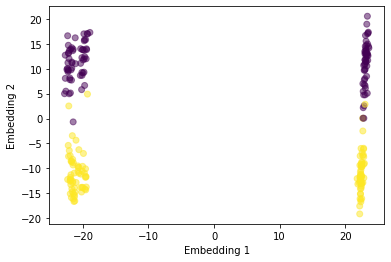

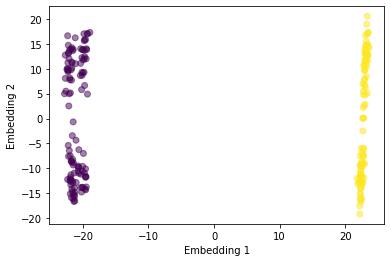

In [ ]:
plt.scatter(encoded_imgs_pca[:,0], encoded_imgs_pca[:,1], c=Y_Platform_test, alpha=0.5)
plt.xlabel('Embedding 1', fontsize=10)
plt.ylabel('Embedding 2', fontsize=10)
plt.show()

plt.scatter(encoded_imgs_pca[:,0], encoded_imgs_pca[:,1], c=Y_ER_test, alpha=0.5)
plt.xlabel('Embedding 1', fontsize=10)
plt.ylabel('Embedding 2', fontsize=10)
plt.show()

In [ ]:
X_encode = encoder_model.predict(np.array(yo))

In [ ]:
%load_ext rpy2.ipython

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [ ]:
%%R
library(devtools)
install_github('theislab/kBET')

In [ ]:
%%R -i Y_Platform_test
batch <- Y_Platform_test

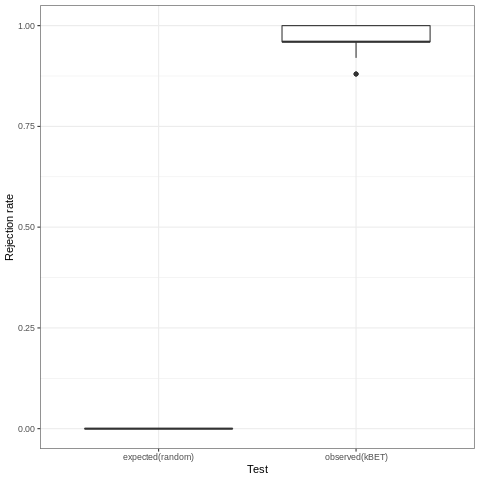

In [ ]:
%%R -i encoded_imgs
#%%R -i batch_label
library(kBET)
#batch <- rep(seq_len(10),each=20)
#data <- matrix(rpois(n = 50000, lambda = 10)*rbinom(50000,1,prob=0.5), nrow=200)
batch.estimate <- kBET(encoded_imgs ,batch, do.pca =FALSE)

In [ ]:
%%R -i batch_label
batch <- batch_label

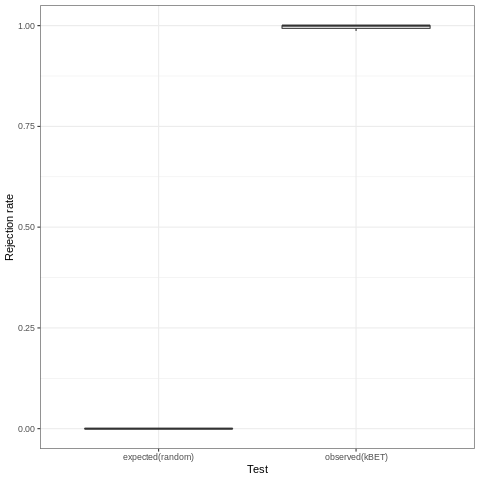

In [ ]:
%%R -i X_encode
#%%R -i batch_label
#library(kBET)
#batch <- rep(seq_len(10),each=20)
#data <- matrix(rpois(n = 50000, lambda = 10)*rbinom(50000,1,prob=0.5), nrow=200)
batch.estimate <- kBET(X_encode ,batch, do.pca =FALSE)

In [ ]:
%%R
result <- batch.estimate$summary$kBET.observed

In [ ]:
x = %R result
print(x[0])

0.9972666666666666


In [ ]:
%%R -i batch_label
batch <- batch_label

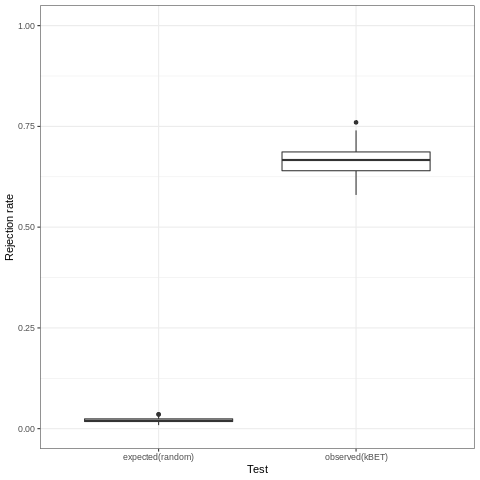

In [ ]:
%%R -i yo
#%%R -i batch_label
library(kBET)
#batch <- rep(seq_len(10),each=20)
#data <- matrix(rpois(n = 50000, lambda = 10)*rbinom(50000,1,prob=0.5), nrow=200)
batch.estimate <- kBET(yo ,batch)
result <- batch.estimate$summary$kBET.observed


In [ ]:
x = %R result
print(x[0])

0.6628666666666667


**LISI**

In [ ]:
import pandas as pd 

In [ ]:
batch_df = pd.DataFrame(batch_label,columns =['batch']) 

In [ ]:
pca = PCA(n_components = 20)
#pca.fit(MinMaxScaler().fit_transform(noise))
yo_pca = pca.fit_transform(MinMaxScaler().fit_transform(yo))

In [ ]:

lisi_result = compute_lisi(yo_pca, batch_df, ['batch'])

In [ ]:
np.mean(lisi_result)

1.591640279833446

# Splatter Data Generation

In [ ]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
%%R
install.packages("akima")

In [ ]:
%%R
remotes::install_github("Oshlack/splatter@RELEASE_3_9") 

R[write to console]: Downloading GitHub repo Oshlack/splatter@RELEASE_3_9



RCurl        (NA -> 1.98-1.2) [CRAN]
IRanges      (NA -> 2.24.1  ) [CRAN]
S4Vectors    (NA -> 0.28.1  ) [CRAN]
XVector      (NA -> 0.30.0  ) [CRAN]
GenomeInfoDb (NA -> 1.26.2  ) [CRAN]
rhdf5filters (NA -> 1.2.0   ) [CRAN]
Rhdf5lib     (NA -> 1.12.1  ) [CRAN]
rhdf5        (NA -> 2.34.0  ) [CRAN]
futile.op... (NA -> 1.0.1   ) [CRAN]
lambda.r     (NA -> 1.2.4   ) [CRAN]
Biobase      (NA -> 2.50.0  ) [CRAN]
HDF5Array    (NA -> 1.18.0  ) [CRAN]
sparseMat... (NA -> 1.2.0   ) [CRAN]
MatrixGen... (NA -> 1.2.0   ) [CRAN]
snow         (NA -> 0.4-3   ) [CRAN]
futile.lo... (NA -> 1.4.3   ) [CRAN]
beachmat     (NA -> 2.6.4   ) [CRAN]
DelayedMa... (NA -> 1.12.2  ) [CRAN]
DelayedArray (NA -> 0.16.1  ) [CRAN]
Summarize... (NA -> 1.20.0  ) [CRAN]
GenomicRa... (NA -> 1.42.0  ) [CRAN]
BiocParallel (NA -> 1.24.1  ) [CRAN]
SingleCel... (NA -> 1.12.0  ) [CRAN]
rsvd         (NA -> 1.0.3   ) [CRAN]
irlba        (NA -> 2.3.3   ) [CRAN]
RcppHNSW     (NA -> 0.3.0   ) [CRAN]
viridis      (NA -> 0.5.1   ) [CRAN]
g

R[write to console]: Installing 37 packages: RCurl, IRanges, S4Vectors, XVector, GenomeInfoDb, rhdf5filters, Rhdf5lib, rhdf5, futile.options, lambda.r, Biobase, HDF5Array, sparseMatrixStats, MatrixGenerics, snow, futile.logger, beachmat, DelayedMatrixStats, DelayedArray, SummarizedExperiment, GenomicRanges, BiocParallel, SingleCellExperiment, rsvd, irlba, RcppHNSW, viridis, ggbeeswarm, scuttle, BiocSingular, BiocNeighbors, locfit, limma, scater, fitdistrplus, edgeR, checkmate

R[write to console]: Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: trying URL 'https://cran.rstudio.com/src/contrib/RCurl_1.98-1.2.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 699583 bytes (683 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[wri

✔  checking for file ‘/tmp/RtmpFpoywh/remotes3f7eda4fe4/Oshlack-splatter-0195bb5/DESCRIPTION’ (350ms)
─  preparing ‘splatter’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  building ‘splatter_1.8.0.tar.gz’
   


R[write to console]: Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
%%R
suppressPackageStartupMessages({
  library(splatter)
  library(scater)
})

In [ ]:
%%R
param <-newSplatParams()

In [ ]:
%%R
param

In [ ]:
%%R
param <- setParam(param, "batchCells", 1500)

In [ ]:
%%R
#sim <- splatSimulate(param, nGenes = 2500, group.prob = c(0.33, 0.33, 0.34), method = "groups",verbose = FALSE)
sim <- splatSimulate(param, nGenes = 2500,verbose = FALSE)

In [ ]:
%%R
head(rowData(sim))

DataFrame with 6 rows and 4 columns
             Gene BaseGeneMean OutlierFactor  GeneMean
      <character>    <numeric>     <numeric> <numeric>
Gene1       Gene1     4.217281       53.2135 54.951506
Gene2       Gene2     9.938768        1.0000  9.938768
Gene3       Gene3     0.164714        1.0000  0.164714
Gene4       Gene4     2.040623        1.0000  2.040623
Gene5       Gene5     1.494863        1.0000  1.494863
Gene6       Gene6     0.952007        1.0000  0.952007


In [ ]:
%%R
head(colData(sim))

DataFrame with 6 rows and 3 columns
             Cell       Batch ExpLibSize
      <character> <character>  <numeric>
Cell1       Cell1      Batch1    67791.1
Cell2       Cell2      Batch1    64651.2
Cell3       Cell3      Batch1    84749.5
Cell4       Cell4      Batch1    72554.3
Cell5       Cell5      Batch1    74375.3
Cell6       Cell6      Batch1    65972.6


In [ ]:
%%R
dim(sim)

[1] 2500 1500


In [ ]:
%%R
Data = counts(sim)

In [ ]:
%%R
Group = colData(sim)$Group

In [ ]:
data_save = %R Data

In [ ]:
Group_save = %R Group

In [ ]:
simulation_save = [data_save, []]

In [ ]:
import pickle
with open("/content/drive/MyDrive/DATA/simulation_8.pickle", 'wb') as handle:
    pickle.dump(simulation_save, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Simulation on Splatter data


In [322]:
import pickle
with open("/content/drive/MyDrive/DATA/simulation_5.pickle", 'rb') as handle:
    XY = pickle.load(handle)

In [323]:
data = XY[0]
group_info = XY[1]
data = data.T

In [324]:
data.shape

(2000, 2500)

In [325]:
le = preprocessing.LabelEncoder()
group_info = le.fit_transform(group_info)


In [326]:
dimen = data.shape[1]
number = data.shape[0]
dimen_n = 100

In [327]:
# generate noise
np.random.seed(10110)
noise_mu_1 = random.uniform(-2,-1,dimen)
noise_mu_2 = random.uniform(1,2,dimen)
noise_sig = datasets.make_spd_matrix(dimen)

weight11 = random.uniform(-1,1,(dimen_n, dimen))
weight12 = random.uniform(-2,2,(dimen, dimen))
weight21 = random.uniform(-2,2,(dimen_n, dimen))
weight22 = random.randint(1,5,(dimen_n, dimen))

noise1 = linear_noise_2(noise_mu_1,noise_sig,dimen, number//2, weight11, weight12, weight22)
noise2 = linear_noise_2(noise_mu_2,noise_sig,dimen, number- number//2,  weight11, weight12, weight22)
noise = np.concatenate([noise1,noise2],axis=0)

In [328]:
batch_info = np.concatenate([np.zeros(number//2), np.ones(number- number//2)], axis = 0)

In [329]:
#indexes = [i for i in range(data.shape[0])]
#np.random.shuffle(indexes)

In [330]:
#data = data[indexes]
#group_info = batch_info 
########### filler for no group
###########
#group_info = group_info[indexes]

In [331]:
data = np.log(data+1)

In [332]:
#scaler = MinMaxScaler()
#scaler.fit(data)
#data=scaler.transform(data)


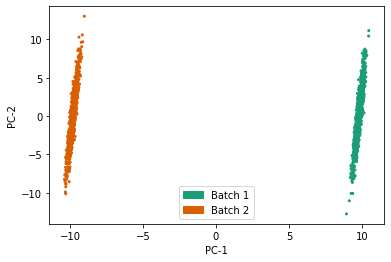

In [333]:
pca = PCA(n_components = 2)
#pca.fit(MinMaxScaler().fit_transform(noise))
noise_pca = pca.fit_transform(MinMaxScaler().fit_transform(noise))



colors = ['#1b9e77','#d95f02']
plt.scatter(noise_pca[:,0], noise_pca[:,1], c=batch_info[:], cmap=matplotlib.colors.ListedColormap(colors),alpha=1.0, s=4.0)
plt.xlabel('PC-1', fontsize=10)
plt.ylabel('PC-2', fontsize=10)
plt.savefig("Sigmoid_noise.png", dpi=300,  bbox_inches = 'tight')
plt.legend(handles=[mpatches.Patch(color='#1b9e77',label='Batch 1'),
                mpatches.Patch(color='#d95f02' ,label='Batch 2'),])
plt.show()

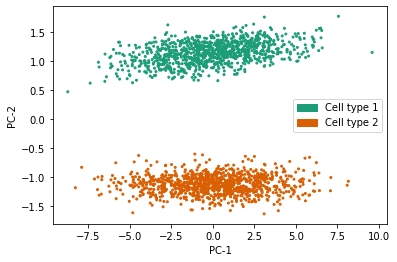

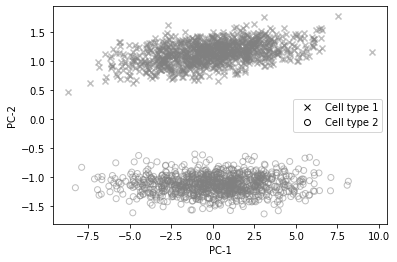

In [334]:
pca = PCA(n_components = 2)
#pca.fit(MinMaxScaler().fit_transform(noise))
data_pca = pca.fit_transform(MinMaxScaler().fit_transform(data))
#plt.scatter(data_pca[:,0], data_pca[:,1], c=group_info[:], cmap=matplotlib.colors.ListedColormap(colors),alpha=1.0, s=4.0)

plt.scatter(data_pca[:,0], data_pca[:,1], c=group_info[:], cmap=matplotlib.colors.ListedColormap(colors),alpha=1.0, s=4.0)

colors = ['#1b9e77','#d95f02']
plt.xlabel('PC-1', fontsize=10)
plt.ylabel('PC-2', fontsize=10)
plt.legend(handles=[mpatches.Patch(color='#1b9e77',label='Cell type 1'),
                mpatches.Patch(color='#d95f02' ,label='Cell type 2'),])
plt.savefig("data_wo_noise.png", dpi=300,  bbox_inches = 'tight')

plt.show()
#########
#With marker
##########
plt.scatter(data_pca[group_info==0,0], data_pca[group_info==0,1],marker = 'x',facecolor = 'grey', alpha=0.5, )

plt.scatter(data_pca[group_info==1,0], data_pca[group_info==1,1] ,marker = 'o',edgecolor = 'grey',  facecolor="None",alpha=0.5,)

colors = ['#1b9e77','#d95f02']
plt.xlabel('PC-1', fontsize=10)
plt.ylabel('PC-2', fontsize=10)
plt.legend(handles=[
                mlines.Line2D([], [], color='white', marker='x',markeredgecolor='black', label='Cell type 1'),
                mlines.Line2D([], [], color='white', marker='o',markeredgecolor='black', label='Cell type 2')])
plt.savefig("data_wo_noise_marker.png", dpi=300,  bbox_inches = 'tight')

plt.show()

In [335]:
print(np.median(data),np.min(data),np.max(data), np.max(noise), np.median(noise), np.min(noise))

1.791759469228055 0.0 7.67275789664251 11.20159991728364 -0.011884396131123798 -10.895128075250552


In [336]:
print(np.sqrt(np.median(np.var((data),axis = 0 )/np.var((noise),axis = 0 ))))

0.3141165952130551


In [337]:
data_ = data  + 0.05*noise

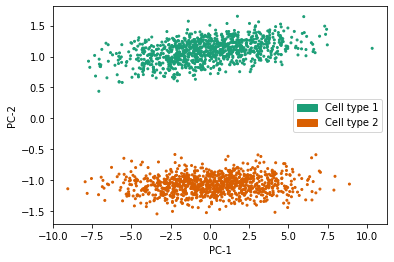

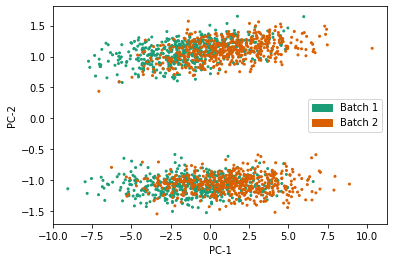

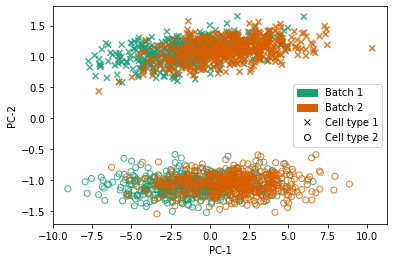

In [338]:

pca = PCA(n_components = 2)
#pca.fit(MinMaxScaler().fit_transform(noise))
data_pca_ = pca.fit_transform(MinMaxScaler().fit_transform(data_))

plt.scatter(data_pca_[:,0], data_pca_[:,1], c=group_info[:],cmap=matplotlib.colors.ListedColormap(colors),alpha=1.0, s=4.0)
colors = ['#1b9e77','#d95f02']
plt.xlabel('PC-1', fontsize=10)
plt.ylabel('PC-2', fontsize=10)
plt.legend(handles=[mpatches.Patch(color='#1b9e77',label='Cell type 1'),
                mpatches.Patch(color='#d95f02' ,label='Cell type 2'),])
plt.savefig("data_w_noise_cell.png", dpi=300,  bbox_inches = 'tight')

plt.show()

plt.scatter(data_pca_[:,0], data_pca_[:,1], c=batch_info[:], cmap=matplotlib.colors.ListedColormap(colors),alpha=1.0, s=4.0)
colors = ['#1b9e77','#d95f02']
plt.xlabel('PC-1', fontsize=10)
plt.ylabel('PC-2', fontsize=10)
plt.legend(handles=[mpatches.Patch(color='#1b9e77',label='Batch 1'),
                mpatches.Patch(color='#d95f02' ,label='Batch 2'),])
plt.savefig("data_w_noise_cell.png", dpi=300,  bbox_inches = 'tight')

plt.show()

########
#Combined figure
##########
plt.scatter(data_pca_[group_info==0,0], data_pca_[group_info==0,1],
            marker = 'x', c=batch_info[group_info==0], cmap=matplotlib.colors.ListedColormap(colors),alpha=0.8, )


plt.scatter(data_pca_[group_info==1,0], data_pca_[group_info==1,1] ,
            edgecolors=[colors[int(i)] for i in batch_info[group_info==1].tolist()],marker = 'o',  facecolor="None",alpha=0.8)

colors = ['#1b9e77','#d95f02']
plt.xlabel('PC-1', fontsize=10)
plt.ylabel('PC-2', fontsize=10)
plt.legend(handles=[mpatches.Patch(color='#1b9e77',label='Batch 1'),
                mpatches.Patch(color='#d95f02' ,label='Batch 2'), 
                mlines.Line2D([], [], color='white', marker='x',markeredgecolor='black', label='Cell type 1'),
                mlines.Line2D([], [], color='white', marker='o',markeredgecolor='black', label='Cell type 2')])
plt.savefig("data_w_noise_batch_bio.png", dpi=300,  bbox_inches = 'tight')

plt.show()

In [339]:
scaler = MinMaxScaler()
scaler.fit(data_)
data_=scaler.transform(data_)

In [340]:
X_train, X_test, Y_Platform_train, Y_Platform_test,Y_ER_train,Y_ER_test = train_test_split(
data_, batch_info, group_info,test_size=0.20,random_state=42)

#Getting separate validation data

X_train, X_val, Y_Platform_train, Y_Platform_val,Y_ER_train,Y_ER_val = train_test_split(
X_train, Y_Platform_train, Y_ER_train ,test_size=0.25,random_state=42)

## Train and result


In [341]:
hybrid_model,encoder_model=get_hybrid_model_1(len(X_train[0]),[200,100,50],1,1)
losses = {
    "p_output": "binary_crossentropy",
   "de_output": "MeanSquaredError",
  "er_output": "binary_crossentropy",
}
lossWeights = {"p_output":2.0, "de_output": 1.0,"er_output":1.0}

#model check pointer 
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('model.h5', verbose=2, save_best_only=True)

hybrid_model.compile(optimizer=Adam(lr=0.0005),loss=losses,loss_weights=lossWeights,metrics={'p_output': 'accuracy', 'er_output': 'accuracy','de_output': 'mse'})
hybrid_model.fit(X_train,{"de_output": X_train, "p_output": Y_Platform_train,"er_output":Y_ER_train},steps_per_epoch = len(X_train) // 32,
                 validation_data=(X_val,
		{"de_output": X_val, "p_output": Y_Platform_val,"er_output":Y_ER_val}),
    callbacks=[model_checkpoint_callback],
    epochs=500,verbose=2)

Epoch 1/500
37/37 - 2s - loss: 12.3244 - p_output_loss: 1.0136 - de_output_loss: 0.2490 - er_output_loss: 0.9874 - p_output_accuracy: 0.5800 - de_output_mse: 0.2490 - er_output_accuracy: 0.5083 - val_loss: 9.3092 - val_p_output_loss: 0.5663 - val_de_output_loss: 0.0363 - val_er_output_loss: 0.6402 - val_p_output_accuracy: 0.6275 - val_de_output_mse: 0.0363 - val_er_output_accuracy: 0.5575

Epoch 00001: val_loss improved from inf to 9.30915, saving model to model.h5
Epoch 2/500
37/37 - 0s - loss: 8.4981 - p_output_loss: 0.5500 - de_output_loss: 0.0612 - er_output_loss: 0.7143 - p_output_accuracy: 0.7175 - de_output_mse: 0.0612 - er_output_accuracy: 0.5900 - val_loss: 7.0328 - val_p_output_loss: 0.2715 - val_de_output_loss: 0.0311 - val_er_output_loss: 0.5578 - val_p_output_accuracy: 0.9925 - val_de_output_mse: 0.0311 - val_er_output_accuracy: 0.5625

Epoch 00002: val_loss improved from 9.30915 to 7.03285, saving model to model.h5
Epoch 3/500
37/37 - 0s - loss: 6.4641 - p_output_loss: 0.

In [342]:
hybrid_model.load_weights('model.h5')

In [343]:
encoded_imgs = encoder_model.predict(X_test)
encoded_imgs_pca = PCA(n_components = 2).fit_transform(encoded_imgs)

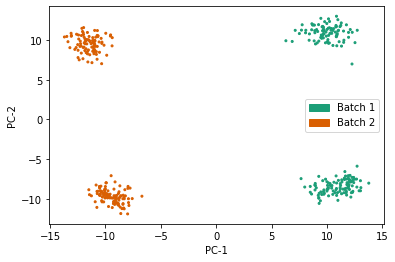

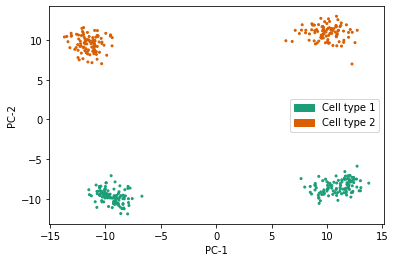

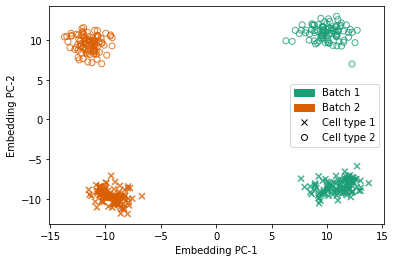

In [344]:
plt.scatter(encoded_imgs_pca[:,0], encoded_imgs_pca[:,1], c=Y_Platform_test, cmap=matplotlib.colors.ListedColormap(colors),alpha=1.0, s=4.0)
colors = ['#1b9e77','#d95f02']
plt.xlabel('PC-1', fontsize=10)
plt.ylabel('PC-2', fontsize=10)

plt.legend(handles=[mpatches.Patch(color='#1b9e77',label='Batch 1'),
                mpatches.Patch(color='#d95f02' ,label='Batch 2'),])
plt.savefig("Encoding_batch.png", dpi=300,  bbox_inches = 'tight')
plt.show()

plt.scatter(encoded_imgs_pca[:,0], encoded_imgs_pca[:,1], c=Y_ER_test, cmap=matplotlib.colors.ListedColormap(colors),alpha=1.0, s=4.0)
colors = ['#1b9e77','#d95f02']
plt.xlabel('PC-1', fontsize=10)
plt.ylabel('PC-2', fontsize=10)
plt.savefig("Encoding_bio.png", dpi=300,  bbox_inches = 'tight')
plt.legend(handles=[mpatches.Patch(color='#1b9e77',label='Cell type 1'),
                mpatches.Patch(color='#d95f02' ,label='Cell type 2'),])
plt.show()

########
#Combined figure
##########
plt.scatter(encoded_imgs_pca[Y_ER_test==0,0], encoded_imgs_pca[Y_ER_test==0,1],
            marker = 'x', c=Y_Platform_test[Y_ER_test==0], cmap=matplotlib.colors.ListedColormap(colors),alpha=0.8, )

plt.scatter(encoded_imgs_pca[Y_ER_test==1,0], encoded_imgs_pca[Y_ER_test==1,1] ,
            edgecolors=[colors[int(i)] for i in Y_Platform_test[Y_ER_test==1].tolist()],marker = 'o',  facecolor="None",alpha=0.8)

colors = ['#1b9e77','#d95f02']
plt.xlabel('Embedding PC-1', fontsize=10)
plt.ylabel('Embedding PC-2', fontsize=10)
plt.legend(handles=[mpatches.Patch(color='#1b9e77',label='Batch 1'),
                mpatches.Patch(color='#d95f02' ,label='Batch 2'), 
                mlines.Line2D([], [], color='white', marker='x',markeredgecolor='black', label='Cell type 1'),
                mlines.Line2D([], [], color='white', marker='o',markeredgecolor='black', label='Cell type 2')])
plt.savefig("encoding_batch_bio.png", dpi=300,  bbox_inches = 'tight')

plt.show()


In [345]:
X_encode = encoder_model.predict(np.array(data_))

In [346]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [347]:
%%R
library(devtools)
install_github('theislab/kBET')

R[write to console]: Skipping install of 'kBET' from a github remote, the SHA1 (4c9dafab) has not changed since last install.
  Use `force = TRUE` to force installation



In [348]:
%%R -i Y_Platform_test
batch <- Y_Platform_test

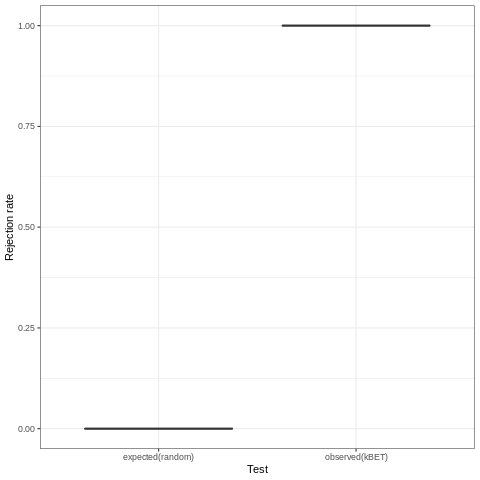

In [349]:
%%R -i encoded_imgs
#%%R -i batch_label
library(kBET)
#batch <- rep(seq_len(10),each=20)
#data <- matrix(rpois(n = 50000, lambda = 10)*rbinom(50000,1,prob=0.5), nrow=200)
batch.estimate <- kBET(encoded_imgs ,batch, do.pca =FALSE)
test_beene = batch.estimate$stats$kBET.observed

In [350]:
%%R
result <- batch.estimate$summary$kBET.observed

In [351]:
x = %R result
print(x[0])

1.0


In [352]:
%%R -i batch_info
batch <- batch_info

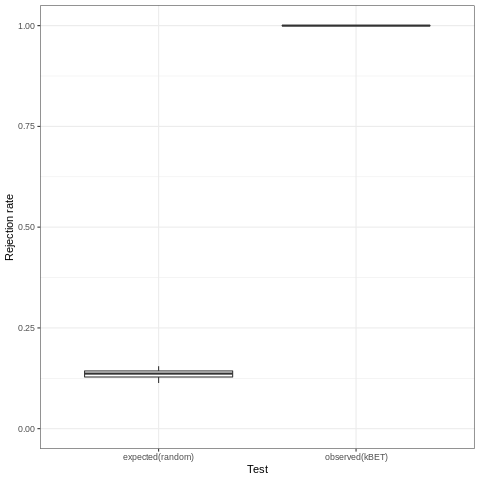

In [353]:
%%R -i X_encode
#%%R -i batch_label
#library(kBET)
#batch <- rep(seq_len(10),each=20)
#data <- matrix(rpois(n = 50000, lambda = 10)*rbinom(50000,1,prob=0.5), nrow=200)
batch.estimate <- kBET(X_encode ,batch, do.pca =FALSE)

In [354]:
%%R
data_beene <- batch.estimate$stats$kBET.observed
result <- batch.estimate$summary$kBET.observed

In [355]:
x = %R result
print(x[0])

1.0


In [356]:
#%%R -i batch_info
#batch <- batch_info

In [357]:
%%R -i Y_Platform_test
batch <- Y_Platform_test

In [358]:
X_test_rev  = scaler.inverse_transform(X_test)

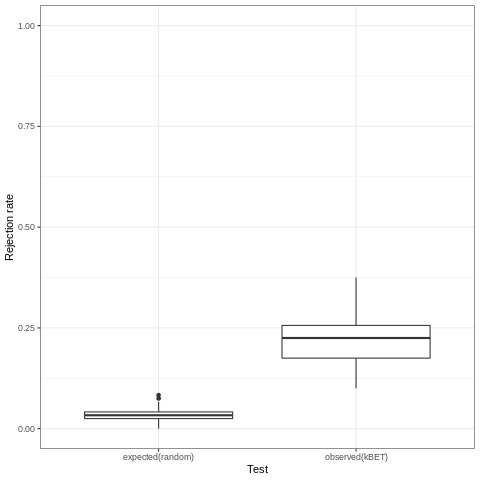

In [359]:
%%R -i X_test_rev
#%%R -i batch_label
library(kBET)
#batch <- rep(seq_len(10),each=20)
#data <- matrix(rpois(n = 50000, lambda = 10)*rbinom(50000,1,prob=0.5), nrow=200)
batch.estimate <- kBET(X_test_rev ,batch)
result <- batch.estimate$summary$kBET.observed
test_kbet <- batch.estimate$stats$kBET.observed


In [360]:
x = %R result
print(x[0])

0.2225


In [361]:
%%R -i batch_info
batch <- batch_info

In [362]:
data_rev  = scaler.inverse_transform(data_)

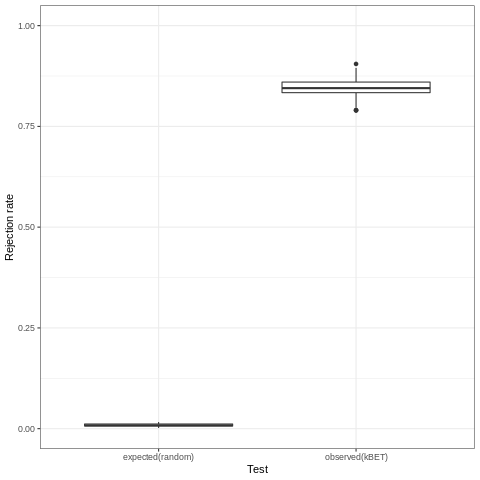

In [363]:
%%R -i data_rev
#%%R -i batch_label
library(kBET)
#batch <- rep(seq_len(10),each=20)
#data <- matrix(rpois(n = 50000, lambda = 10)*rbinom(50000,1,prob=0.5), nrow=200)
batch.estimate <- kBET(data_rev ,batch)
result <- batch.estimate$summary$kBET.observed
data_kbet <- batch.estimate$stats$kBET.observed

In [364]:
%%R
png("simulation_box.png", width = 150, height = 150, units='mm', res = 300)
par(mar=c(7,5,1,1))
boxplot(test_beene, test_kbet, data_kbet,
at = c(1,2,3),
names = c("BEENE\n(Test set)", "KBET\n(Test set)", "KBET"),
las = 2,
xlab = "Rejection rate",
col = c("#1b9e77","#d95f02","#7570b3"),
border = "brown",
horizontal = TRUE,
notch = FALSE,
las=2
)
dev.off()

png 
  2 


**LISI**

In [365]:
import pandas as pd 

In [366]:
batch_df = pd.DataFrame(batch_info,columns =['batch']) 

In [367]:
pca = PCA(n_components = 50)
#pca.fit(MinMaxScaler().fit_transform(noise))
data__pca = pca.fit_transform(MinMaxScaler().fit_transform(data_))

In [368]:

lisi_result = compute_lisi(data__pca, batch_df, ['batch'])

In [369]:
np.median(lisi_result)

1.0444589701005742

In [370]:
batch_df = pd.DataFrame(Y_Platform_test,columns =['batch']) 
#data__pca = pca.fit_transform(MinMaxScaler().fit_transform(data_))
lisi_result = compute_lisi(encoded_imgs, batch_df, ['batch'])
np.median(lisi_result)

1.0

#Process Kbet Data_1

In [ ]:
data_1 = np.loadtxt(open("/content/drive/MyDrive/DATA/Kbet 2 tech rep/GSM1599495_ES_d0_biorep_dtechrep1.csv/GSM1599495_ES_0_biorep_techrep1.csv", "rb"),dtype=str, delimiter=",")

In [ ]:
data_1 = data_1[:,1:]

In [ ]:
data_1 = data_1.astype('float64')

In [ ]:
limit = data_1.shape[0]*0.20
print(limit)
print(data_1.shape[0])
print(data_1.shape[1])

4835.0
24175
2509


In [ ]:
#cell selection
#Barr = [np.count_nonzero(data_1[:,i])>limit for i in range(data_1.shape[1])]
#data_1 = data_1[:,Barr]

In [ ]:
data_1 = data_1.T

In [ ]:
data_2 = np.loadtxt(open("/content/drive/MyDrive/DATA/Kbet 2 tech rep/GSM1599496_ES_d0_biorep_techrep2.csv/GSM1599496_ES_d0_biorep_techrep2.csv", "rb"),dtype=str, delimiter=",")
data_2 = data_2[:,1:]
data_2 = data_2.astype('float64')

limit = data_2.shape[0]*0.20
print(limit)

#Barr = [np.count_nonzero(data_2[:,i])>limit for i in range(data_2.shape[1])]
#data_2 = data_2[:,Barr]

data_2 = data_2.T


4835.0


In [ ]:
#batch assignment
data_combined = np.concatenate([data_1, data_2], axis = 0)
batch_1 = np.zeros(data_1.shape[0])
batch_2 = np.ones(data_2.shape[0])
batch_combined = np.concatenate([batch_1, batch_2], axis = 0)

In [ ]:
print(data_combined.shape)
print(batch_combined.shape)

(5952, 24175)
(5952,)


In [ ]:
# gene selection
limit = data_combined.shape[0]*0.35
print(limit)

Barr = [np.sum(data_combined[:,i]>=4)>=2 for i in range(data_combined.shape[1])]


2083.2


In [ ]:
np.sum(Barr)

15769

In [ ]:
data_combined_final = data_combined[:,Barr]
print(data_combined_final.shape)

(5952, 10513)


In [ ]:
data_save = [data_combined_final, batch_combined]

In [ ]:
import pickle
with open("/content/drive/MyDrive/DATA/Kbet 2 tech rep/Data_2.pickle", 'wb') as handle:
    pickle.dump(data_save, handle, protocol=pickle.HIGHEST_PROTOCOL)



#Kbet data_1 result

In [ ]:
# Load data (deserialize)
#import pickle
#with open("/content/drive/MyDrive/DATA/Kbet 2 tech rep/Data_2.pickle", 'rb') as handle:
#    XY = pickle.load(handle)

In [ ]:
#X = XY[0]
#batch_info = XY[1]

In [ ]:
#X = np.log2(X+1)

New data from writer

In [ ]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
%%R
Canteen_clean <- readRDS("/content/drive/MyDrive/DATA/DATA_KBET/d0_Counts.rds")

In [ ]:
%%R
dim(Canteen_clean)

[1] 11308  5952


In [ ]:
X = %R Canteen_clean

In [ ]:
X = X.T

In [ ]:
batch_info = np.concatenate([np.zeros(2509), np.ones(3443)], axis = 0)

In [ ]:
X = np.log2(X+1)

In [ ]:
batch_info = batch_info.astype('float64')
X = X.astype('float64')

## end data load

In [ ]:
!pip install combat

In [ ]:
X=X.T
from combat.pycombat import pycombat
import pandas as pd
X = pycombat( pd.DataFrame(X),batch_info)
X = X.to_numpy()
X = X.T

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


In [ ]:
scaler = MinMaxScaler()
scaler.fit(X)
Xs=scaler.transform(X)

In [ ]:
pca = PCA(n_components = 2)
pca.fit(Xs)
X_pca = pca.transform(Xs)

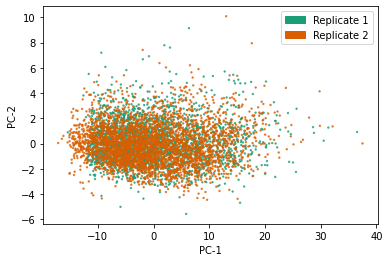

In [ ]:
colors = ['#1b9e77','#d95f02']
plt.scatter(X_pca[:,0], X_pca[:,1], c=batch_info[:], cmap=matplotlib.colors.ListedColormap(colors),alpha=0.7, s=2.0)
plt.xlabel('PC-1', fontsize=10)
plt.ylabel('PC-2', fontsize=10)
plt.legend(handles=[mpatches.Patch(color='#1b9e77',label='Replicate 1'),
                mpatches.Patch(color='#d95f02' ,label='Replicate 2'),])
plt.savefig("kb_data_pc.png", dpi=300)

plt.show()

In [ ]:
X_train, X_test, Y_Platform_train, Y_Platform_test,Y_ER_train,Y_ER_test = train_test_split(
Xs, batch_info, batch_info, test_size=0.20, random_state=42)

#Getting separate validation data

X_train, X_val, Y_Platform_train, Y_Platform_val,Y_ER_train,Y_ER_val = train_test_split(
X_train, Y_Platform_train, Y_ER_train ,test_size=0.25,random_state=42)

In [ ]:
np.random.seed(10110)
hybrid_model,encoder_model=get_hybrid_model_1(len(X_train[0]),[200,100,50],1,1, islarge=0.40)
losses = {
    "p_output": "binary_crossentropy",
   "de_output": "MeanSquaredError",
  "er_output": "binary_crossentropy",
}

#model check pointer 
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('model.h5', verbose=2, save_best_only=True)

# Pre train#
###########
#lossWeights = {"p_output":0.0, "de_output": 1.0,"er_output":0.0}

#hybrid_model.compile(optimizer=Adam(lr=0.0005),loss=losses,loss_weights=lossWeights,metrics={'p_output': 'accuracy', 'er_output': 'accuracy','de_output': 'mse'})
#hybrid_model.fit(X_train,{"de_output": X_train, "p_output": Y_Platform_train,"er_output":Y_ER_train},steps_per_epoch = len(X_train) // 32,
#                 validation_data=(X_val,
#		{"de_output": X_val, "p_output": Y_Platform_val,"er_output":Y_ER_val}),
#    callbacks=[model_checkpoint_callback],
#    epochs=20,verbose=2)
#hybrid_model.load_weights('model.h5')
###############
##end pre-train

lossWeights = {"p_output":5.0, "de_output": 0.001,"er_output":0.0}

hybrid_model.compile(optimizer=Adam(lr=0.0005),loss=losses,loss_weights=lossWeights,metrics={'p_output': 'accuracy', 'er_output': 'accuracy','de_output': 'mse'})
hybrid_model.fit(X_train,{"de_output": X_train, "p_output": Y_Platform_train,"er_output":Y_ER_train},
                 validation_data=(X_val,
		{"de_output": X_val, "p_output": Y_Platform_val,"er_output":Y_ER_val}),
    callbacks=[model_checkpoint_callback],
    epochs=550,verbose=2)


In [ ]:
hybrid_model.load_weights('model.h5')

In [ ]:
encoded_imgs = encoder_model.predict(X_test)

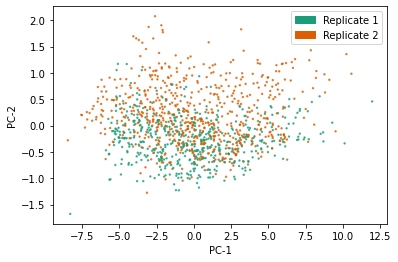

In [ ]:
encoded_imgs_pc = PCA(n_components = 2).fit_transform(encoded_imgs)
plt.scatter(encoded_imgs_pc[:,0], encoded_imgs_pc[:,1], c=Y_Platform_test, cmap=matplotlib.colors.ListedColormap(colors),alpha=0.7, s=2.0)
plt.xlabel('PC-1', fontsize=10)
plt.ylabel('PC-2', fontsize=10)
plt.legend(handles=[mpatches.Patch(color='#1b9e77',label='Replicate 1'),
                mpatches.Patch(color='#d95f02' ,label='Replicate 2'),])
plt.savefig("kb_data_enco.png", dpi=300,  bbox_inches = 'tight')
plt.show()

In [ ]:
X_encode = encoder_model.predict(np.array(Xs))

In [ ]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
%%R
library(devtools)
install_github('theislab/kBET')

R[write to console]: Skipping install of 'kBET' from a github remote, the SHA1 (4c9dafab) has not changed since last install.
  Use `force = TRUE` to force installation



In [ ]:
%%R -i Y_Platform_test
batch <- Y_Platform_test

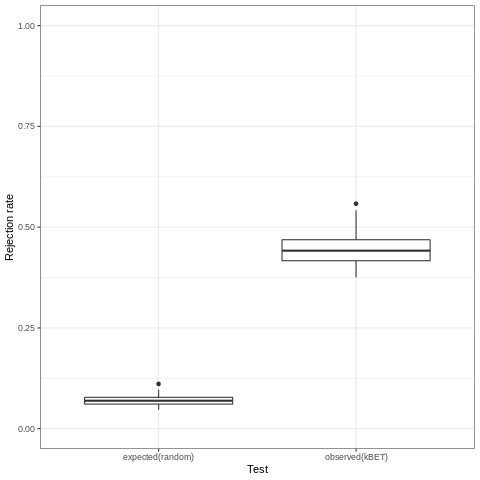

In [ ]:
%%R -i encoded_imgs
#%%R -i batch_label
library(kBET)
#batch <- rep(seq_len(10),each=20)
#data <- matrix(rpois(n = 50000, lambda = 10)*rbinom(50000,1,prob=0.5), nrow=200)
batch.estimate <- kBET(encoded_imgs ,batch, do.pca =FALSE)
test_beene = batch.estimate$stats$kBET.observed

In [ ]:
%%R
result <- batch.estimate$summary$kBET.observed

In [ ]:
x = %R result
print(x[0])

0.44666666666666666


In [ ]:
%%R -i batch_info
batch <- batch_info

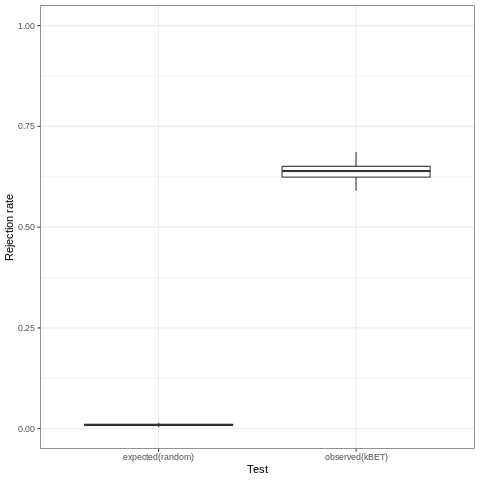

In [ ]:
%%R -i X_encode
#%%R -i batch_label
#library(kBET)
#batch <- rep(seq_len(10),each=20)
#data <- matrix(rpois(n = 50000, lambda = 10)*rbinom(50000,1,prob=0.5), nrow=200)
batch.estimate <- kBET(X_encode ,batch, do.pca =FALSE)

In [ ]:
%%R
data_beene <- batch.estimate$stats$kBET.observed
result <- batch.estimate$summary$kBET.observed

In [ ]:
x = %R result
print(x[0])

0.6378523489932886


In [ ]:
#%%R -i batch_info
#batch <- batch_info

In [ ]:
%%R -i Y_Platform_test
batch <- Y_Platform_test

In [ ]:
X_test_rev  = scaler.inverse_transform(X_test)

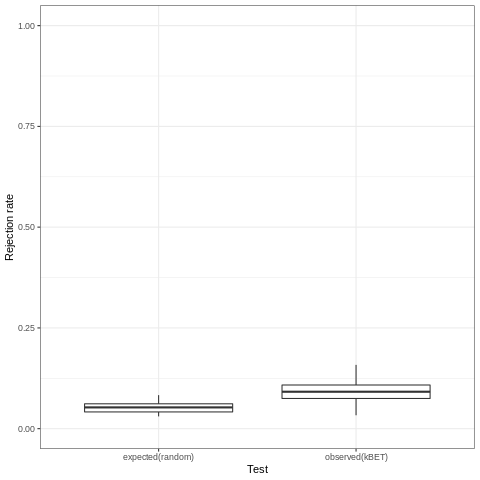

In [ ]:
%%R -i X_test_rev
#%%R -i batch_label
library(kBET)
#batch <- rep(seq_len(10),each=20)
#data <- matrix(rpois(n = 50000, lambda = 10)*rbinom(50000,1,prob=0.5), nrow=200)
batch.estimate <- kBET(X_test_rev ,batch)
result <- batch.estimate$summary$kBET.observed
test_kbet <- batch.estimate$stats$kBET.observed


In [ ]:
x = %R result
print(x[0])

0.0945


In [ ]:
%%R -i batch_info
batch <- batch_info

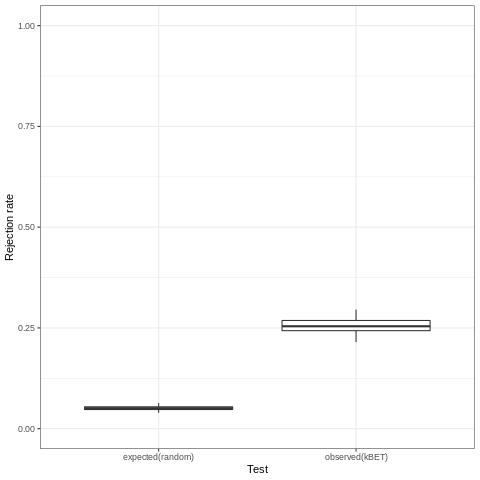

In [ ]:
%%R -i X
#%%R -i batch_label
library(kBET)
#batch <- rep(seq_len(10),each=20)
#data <- matrix(rpois(n = 50000, lambda = 10)*rbinom(50000,1,prob=0.5), nrow=200)
batch.estimate <- kBET(X ,batch)
result <- batch.estimate$summary$kBET.observed
data_kbet <- batch.estimate$stats$kBET.observed

In [ ]:
%%R
png("simulation_box.png", width = 150, height = 150, units='mm', res = 300)
par(mar=c(7,5,1,1))
boxplot(test_beene, test_kbet, data_kbet,
at = c(1,2,3),
names = c("BEENE\n(Test set)", "KBET\n(Test set)", "KBET"),
las = 2,
xlab = "Rejection rate",
col = c("#1b9e77","#d95f02","#7570b3"),
border = "brown",
horizontal = TRUE,
notch = FALSE,
las=2
)
dev.off()

png 
  2 







## **LISI**

In [ ]:
import pandas as pd 

In [ ]:
batch_df = pd.DataFrame(batch_info,columns =['batch']) 

In [ ]:
pca = PCA(n_components = 50)
#pca.fit(MinMaxScaler().fit_transform(noise))
data__pca = pca.fit_transform(MinMaxScaler().fit_transform(Xs))

In [ ]:

lisi_result = compute_lisi(data__pca, batch_df, ['batch'])

In [ ]:
np.median(lisi_result)

1.8388806059626823

In [ ]:
batch_df = pd.DataFrame(Y_Platform_test,columns =['batch']) 
#data__pca = pca.fit_transform(MinMaxScaler().fit_transform(data_))
lisi_result = compute_lisi(encoded_imgs, batch_df, ['batch'])
np.median(lisi_result)

1.7865045502472419

#KBET - 2 Processs

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R
Canteen_clean <- readRDS("/content/drive/MyDrive/DATA/DATA_KBET/d0_Counts.rds")

In [ ]:
%%R
dim(Canteen_clean)

[1] 11308  5952


In [ ]:
data = %R Canteen_clean

In [ ]:
data = data.T

In [ ]:
batch = np.concatenate([np.zeros(2509), np.ones(3443)], axis = 0)

In [ ]:
data = np.log2(data+1)

In [ ]:
batch = batch.astype('float64')
data = data.astype('float64')

In [ ]:
scaler = MinMaxScaler()
scaler.fit(data)
Xs=scaler.transform(data)

In [ ]:
pca = PCA(n_components = 2)
pca.fit(Xs)
X_pca = pca.transform(Xs)

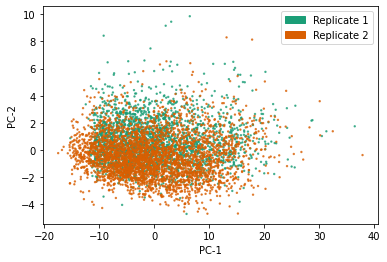

In [ ]:
colors = ['#1b9e77','#d95f02']
plt.scatter(X_pca[:,0], X_pca[:,1], c=batch[:], cmap=matplotlib.colors.ListedColormap(colors),alpha=0.7, s=2.0)
plt.xlabel('PC-1', fontsize=10)
plt.ylabel('PC-2', fontsize=10)
plt.legend(handles=[mpatches.Patch(color='#1b9e77',label='Replicate 1'),
                mpatches.Patch(color='#d95f02' ,label='Replicate 2'),])
plt.savefig("kb_data_pc.png", dpi=300)

plt.show()

# Dull

In [ ]:
hybrid_model,encoder_model=get_hybrid_model_1(1000,[200,100,50],1,1)

In [ ]:
hybrid_model.save('my_model.h5', save_format='h5')